# YIELD CHANGE TRAJECTORYS ACROSS VARIETIES AND SOWING MONTHS

In [1]:
"""
Plot 1 - Variation of simulated (across three cultivar maturity groups) vs. reported maize yield over years 
         a. With reported sowing, with difference among varieties
         b. With optimal sowing month for mean climate, with difference among varieties
         c. With optimal sowing month adapting to year variability, with difference among varieties
"""
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
fer="wfer_wa38hi40"  #try wfer_wa40hi40
G1="" #or _G1 #if remove grids that over >80% yearly yield is less than 1
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"+fer+"\\"

In [12]:
#A table containing area-weighted yield and production
#sea 1=primary 2=minor 3=total/combined
#result=pd.DataFrame(columns=['sowtype','season','variety','year','yld','prod'])
result=pd.DataFrame(columns=['sowtype','type','cul','sea']+[x for x in range(1971,2022)])
##########################################FAO#############################################################
#Reported yield and production, computed from detrended yield, production = detrend yield  x max(area in 1971-2021)
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\FAOSTAT_African_Countries_data_en_1-21-2025.csv")
#########################################Real FAO production of past 10 years, 2014-2023##################
temp=df.loc[(df['Area']=='Africa')&(df['Year']>2018)&(df['Element']=='Production'),'Value'].tolist()
result.loc[len(result),]=['fao','prod','real','2019-2023']+[np.nan]*(51-len(temp))+[x/1000000 for x in temp]
#########################################Estimated production by detrended FAO yield######################
df=df[(df['Area']=='Africa')&(df['Year']>1970)&(df['Year']<2022)][['Element','Year','Value']]
#fao=(df[df['Element']=='Yield']['Value']*df[df['Element']=='Area harvested']['Value'].max()/1000000000).values
temp=df.loc[df['Element']=='Yield',['Year','Value']]
temp.columns=['year','value']
slope, intercept, r_value, p_value, std_err = stats.linregress(temp['year'], temp['value'])
yld=((temp['value']+(2023-temp['year'])*slope)/1000).tolist()  #detrend yield to 2020 level
result.loc[len(result),]=['fao','yld','yld_detrend2020','']+[round(x,3) for x in yld]
prod=(np.array(yld)*df[(df['Year']>2011)&(df['Year']<2022)&(df['Element']=='Area harvested')]['Value'].mean()/1000000).tolist()
result.loc[len(result),]=['fao','prod','yid_detrend2020','']+prod
####################################SIMULATED YIELD#########################################################
#Resport sowing month and area for the primary and minor maize
in_dir="D:\\works\\AfricaMzSg\\input\\"
#reported sowing month
sow=pd.read_csv(in_dir+"Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m','A']]
sow.columns=['SIMUNIT','se1m','se2m','A']
area=pd.read_csv(in_dir+"Africa_SIMUNIT_MZ_PhysicalArea.csv")
area=area.merge(sow[['SIMUNIT','A']],how='outer').fillna(0)
area['se1a']=area['PhysicalArea']#Area of the primary maize is set to the physical area of maize in around 2020 (SPAM)
area['se2a']=area['A']-area['PhysicalArea']#Actual area of second maize is not know, setting to Physical-Harvest>0
area[area<0]=0
sow=sow[['SIMUNIT','se1m','se2m']]
area=area[['SIMUNIT','se1a','se2a']]
#######################################SIMULATED VALUE# WITHOUT FERTILIZER#################################
sowing_window=['ReportedSow','FixedSow','OptimumFixedSow','OptimumYearSow']
in_dir="D:/works/AfricaMzSg/output/"
for sw in sowing_window:
    df=pd.read_csv(in_dir+"mz_yield_"+sw+"_"+fer+".txt",delim_whitespace=True) #change here for fertilizer
    for cul in [1,2,3]:
        #seson 1
        temp=df[(df['matu']==cul)&(df['sea']==1)].fillna(0)
        #for season 1, we always extract yield, for season 2, we extract yield for grids with >80% yearly yield greater 1
        #temp['G1count']=[(temp.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in temp.index]
        #temp=temp[temp.G1count>=(51*0.8)].drop('G1count',axis=1) #only keep rows that >80% years yield greater 1 
        temp=temp.merge(area,how='left').fillna(0) #merge maize area
        yld1=[np.dot(temp["yld_"+str(x)].values,temp['se1a'].values.T)/sum(temp['se1a']) for x in range(1971,2022)]
        prod1=[np.dot(temp["yld_"+str(x)].values,temp['se1a'].values.T)/1000000 for x in range(1971,2022)]
        result.loc[len(result),]=[sw,'yld',cul,1]+[round(x,3) for x in yld1]
        result.loc[len(result),]=[sw,'prod',cul,1]+prod1
        a1=sum(temp['se1a'])
        #season2
        temp=df[(df['matu']==cul)&(df['sea']==2)].fillna(0)
        temp=temp.merge(area,how='left').fillna(0)
        yld2=[np.dot(temp["yld_"+str(x)].values,temp['se2a'].values.T)/sum(temp['se2a']) for x in range(1971,2022)]
        prod2=[np.dot(temp["yld_"+str(x)].values,temp['se2a'].values.T)/1000000 for x in range(1971,2022)]
        a2=sum(temp['se2a'])
        result.loc[len(result),]=[sw,'yld',cul,2]+[round(x,3) for x in yld2]
        result.loc[len(result),]=[sw,'prod',cul,2]+prod2
        #aggreagted yield
        yld=((np.array(prod1)+np.array(prod2))*1000000/(a1+a2)).tolist()
        result.loc[len(result),]=[sw,'yld',cul,3]+[round(x,3) for x in yld]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\1_mz_Africa_WeightedYld_Production_"+fer+G1+".csv", index=False)

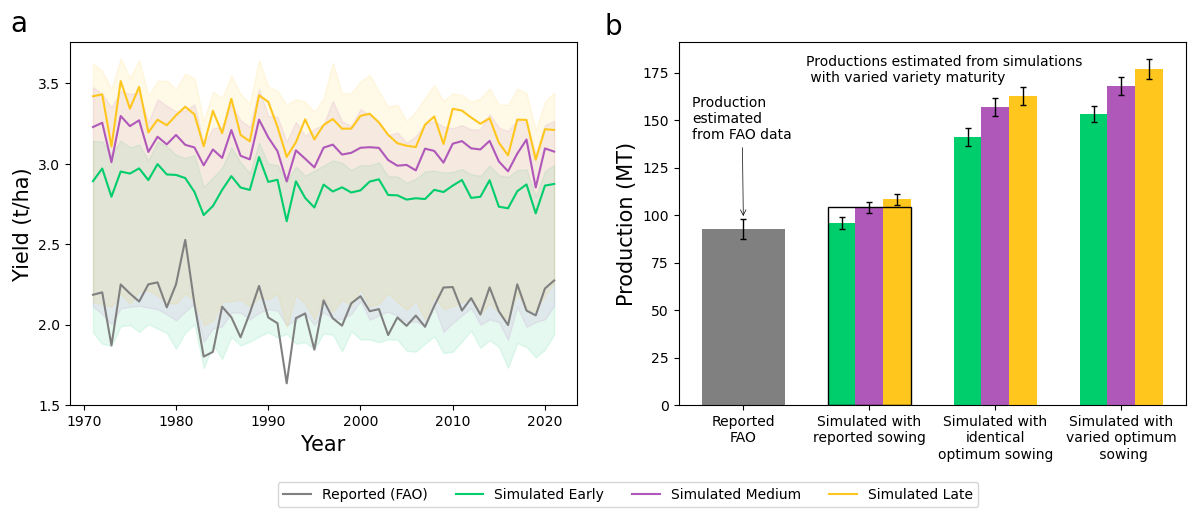

In [17]:
#Plotting  -With fertilizer
fer="wfer_wa38hi40"
type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\1_mz_Africa_WeightedYld_Production_"+fer+G1+".csv")
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"+fer.split("_")[0]+"\\"
type_colors=["#00CD6C", "#AF58BA", "#FFC61E"]
width_ratios = [1, 1]
label=['Early','Medium','Late']

#####################################
fig, axes = plt.subplots(1, 2, figsize=(12,5.5),gridspec_kw={'width_ratios': width_ratios}) #
#fig, ax = plt.subplots(1, 2, figsize=(13,4.5))
sw=['fao','ReportedSow','FixedSow','OptimumYearSow']  #['ReportedSow','FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
label_name=['Simulated Early', 'Simulated Medium','Simulated Late']
x=list(range(1971,2022))
y=result[(result['sowtype']=='fao')&(result['type']=='yld')].iloc[0,4:].values
axes[0].plot(x,y,color='grey',label="Reported (FAO)") #FAO
for cul in range(3):
    y1=result[(result['sowtype']=='ReportedSow')&(result['type']=='yld')&(result['sea']=='3')&(result['cul']==str(cul+1))].iloc[0,4:].values*0.7
    y2=result[(result['sowtype']=='OptimumYearSow')&(result['type']=='yld')&(result['sea']=='3')&(result['cul']==str(cul+1))].iloc[0,4:].values*0.7
    axes[0].fill_between(x,[float(y) for y in y1],[float(y) for y in y2],color=type_colors[cul],alpha=0.1)
    y=result[(result['sowtype']=='OptimumFixedSow')&(result['type']=='yld')&(result['sea']=='3')&(result['cul']==str(cul+1))].iloc[0,4:].values*0.7
    axes[0].plot(x,y,color=type_colors[cul],label=label_name[cul])
#Bar
mzarea=area[['se1a','se2a']].sum().sum()
xtick = [1,2,3,4]
bar_width=0.66
#fao
#mean=np.mean(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
#sd=np.std(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
mean=result.loc[(result['sowtype']=="fao")&(result['cul']=="real"),[str(yr) for yr in range(2017,2022)]].mean(axis=1).tolist()[0]
sd=result.loc[(result['sowtype']=="fao")&(result['cul']=="real"),[str(yr) for yr in range(2017,2022)]].std(axis=1).tolist()[0]
axes[1].bar(xtick[0],mean,bar_width,yerr=sd,color='grey',error_kw=dict(lw=1, capsize=2, capthick=1))

#simulated
for ty in [1,2,3]: #sowing type
    for cul in [1,2,3]: #variety
        mean1=result[(result['sowtype']==sw[ty])&(result['type']=="yld")&
                             (result['sea']=='1')&(result['cul']==str(cul))][[str(yr) for yr in range(1971,2022)]].values*(area.se1a.sum())/1000000
        mean2=result[(result['sowtype']==sw[ty])&(result['type']=="prod")&
                             (result['sea']=='2')&(result['cul']==str(cul))][[str(yr) for yr in range(1971,2022)]].values*(area.se2a.sum())/1000000
        sd=(mean1+mean2).std()
        axes[1].bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean2.mean(),bar_width/3,color=type_colors[cul-1])
        axes[1].bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean1.mean(),bar_width/3,color=type_colors[cul-1],yerr=sd,
               error_kw=dict(lw=1, capsize=2, capthick=1))
reportedsow_mean=104
axes[1].bar(2,reportedsow_mean,bar_width,edgecolor='black',linewidth=1,facecolor='none')

axes[0].set_xlabel("Year",fontsize=15)
axes[0].set_yticks([1.5,2,2.5,3,3.5])
axes[0].set_ylabel("Yield (t/ha)",fontsize=15)
axes[1].set_ylabel("Production (MT)",fontsize=15)
#axes[1].set_ylabel("")
axes[1].set_xticks([1,2,3,4],['Reported\nFAO','Simulated with\nreported sowing','Simulated with\nidentical\noptimum sowing',
                              'Simulated with\nvaried optimum\n sowing'],fontsize=10)
axes[0].text(1962,3.82,"a",fontsize=20)
axes[1].text(-0.10,195,"b",fontsize=20)
axes[0].legend(loc='lower center',ncol=4,fontsize=10,bbox_to_anchor=(1.1, -0.30))
axes[1].annotate(
    "Production \nestimated\nfrom FAO data",  # The text to display
    xy=(1, 98),  # The point the arrow points to
    xytext=(0.595, 140),  # The point where the text is placed
    arrowprops=dict(facecolor="black", arrowstyle="->",linewidth=0.5),  # Arrow properties
    fontsize=10
)
axes[1].text(1.5,170,"Productions estimated from simulations\n with varied variety maturity",fontsize=10)
plt.subplots_adjust(left=0.06, bottom=0.22,top=0.88,right=0.99)
fig.savefig(fig_dir+"MS1_mz_cul_yield_prod_change_"+fer+G1+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS1_mz_cul_yield_prod_change_"+fer+G1+".pdf",format="pdf",dpi=300)

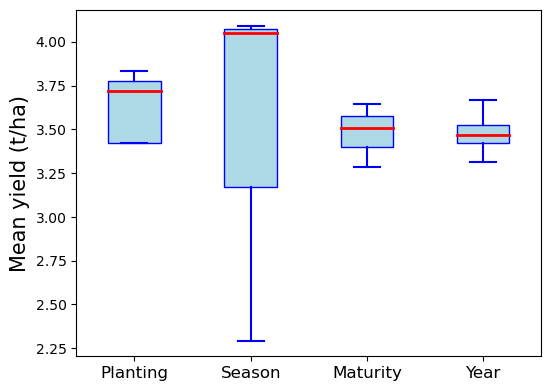

In [18]:
#Yield variations caused by planting date and maturity groups
#Supplementary plot 
fer="wfer_wa38hi40"
G1=""
type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\1_mz_Africa_WeightedYld_Production_"+fer+G1+".csv")
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"+fer.split("_")[0]+"\\"
result=result[(result.sowtype!='fao')&(result.type=='yld')&(result.sea!=3)]
result['mean']=result.iloc[:,4:].mean(axis=1)
type=['Planting','Season','Maturity','Year']
data=[] #Create a empty list
data.append(result[['sowtype','mean']].groupby('sowtype').mean().reset_index()['mean'].tolist()) #Planting
data.append(result[['sea','mean']].groupby('sea').mean().reset_index()['mean'].tolist()) #Season
data.append(result[['cul','mean']].groupby('cul').mean().reset_index()['mean'].tolist()) #Maturity
data.append(result[[str(yr) for yr in range(1971,2022)]].mean().tolist())  #Year
fig=plt.figure(figsize=(6,4.5))
plt.boxplot(data,vert=True,patch_artist=True,showmeans=False,showfliers=False,
           boxprops=dict(facecolor='lightblue',color="blue"),
           medianprops=dict(color="red",linewidth=2),
           whiskerprops=dict(color="blue",linewidth=1.5),
           capprops=dict(color="blue",linewidth=1.5))
plt.xticks([1,2,3,4],type,fontsize=12)
plt.ylabel("Mean yield (t/ha)",fontsize=15)
plt.show()
#fig.savefig(fig_dir+"MS1_mz_YieldVariationAcrossFactors_"+fer+G1+".png",format="png",dpi=300, bbox_inches='tight')

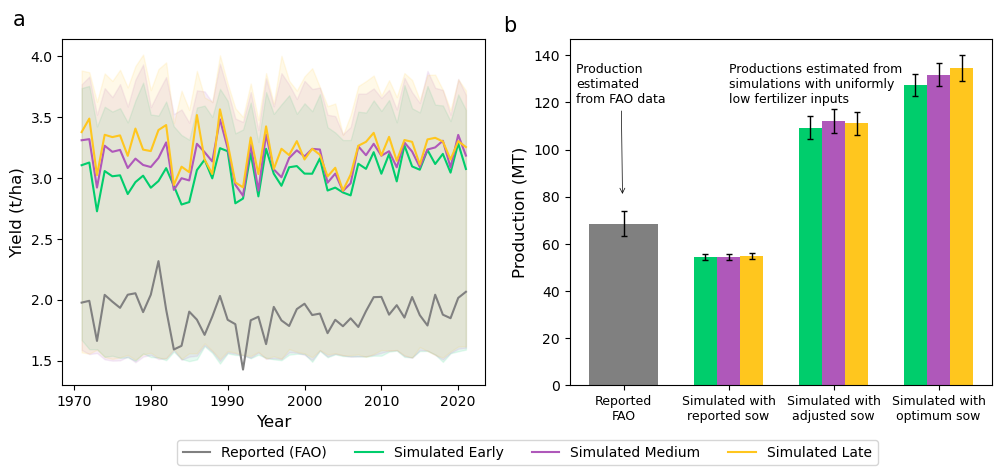

In [406]:
#Plotting  -Without fertilizer
type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+""\\1_mz_Africa_WeightedYld_Production_"+fer+".csv")
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"
type_colors=["#00CD6C", "#AF58BA", "#FFC61E"]
width_ratios = [1, 1]
label=['Early','Medium','Late']

fig, axes = plt.subplots(1, 2, figsize=(12,4.5),gridspec_kw={'width_ratios': width_ratios}) #
#fig, ax = plt.subplots(1, 2, figsize=(13,4.5))
sw=['fao','ReportedSow','FixedSow','OptimumYearSow']  #['ReportedSow','FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
label_name=['Simulated Early', 'Simulated Medium','Simulated Late']
x=list(range(1971,2022))
y=result[(result['sowtype']=='fao')&(result['type']=='yld')].iloc[0,4:].values
axes[0].plot(x,y,color='grey',label="Reported (FAO)") #FAO
for cul in range(3):
    y1=result[(result['sowtype']=='ReportedSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==cul+1)].iloc[0,4:].values#*0.6
    y2=result[(result['sowtype']=='OptimumYearSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==cul+1)].iloc[0,4:].values#*0.6
    axes[0].fill_between(x,[float(y) for y in y1],[float(y) for y in y2],color=type_colors[cul],alpha=0.1)
    y=result[(result['sowtype']=='OptimumFixedSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==cul+1)].iloc[0,4:].values#*0.6
    axes[0].plot(x,y,color=type_colors[cul],label=label_name[cul])

#Bar
mzarea=area[['se1a','se2a']].sum().sum()
xtick = [1,2,3,4]
bar_width=0.66
#fao
mean=np.mean(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
sd=np.std(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
axes[1].bar(xtick[0],mean,bar_width,yerr=sd,color='grey',error_kw=dict(lw=1, capsize=2, capthick=1))

#simulated
for ty in [1,2,3]: #sowing type
    for cul in [1,2,3]: #variety
        mean1=result[(result['sowtype']==sw[ty])&(result['type']=="yld")&
                             (result['sea']==1)&(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].values*(area.se1a.sum())/1000000
        mean2=result[(result['sowtype']==sw[ty])&(result['type']=="prod")&
                             (result['sea']==2)&(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].values*(area.se2a.sum())/1000000
        sd=(mean1+mean2).std()
        axes[1].bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean2.mean(),bar_width/3,color=type_colors[cul-1])
        axes[1].bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean1.mean(),bar_width/3,color=type_colors[cul-1],yerr=sd,
               error_kw=dict(lw=1, capsize=2, capthick=1))
axes[0].set_xlabel("Year",fontsize=12)
axes[0].set_ylabel("Yield (t/ha)",fontsize=12)
axes[1].set_ylabel("Production (MT)",fontsize=12)
#axes[1].set_ylabel("")
axes[1].set_xticks([1,2,3,4],['Reported\nFAO','Simulated with\nreported sow','Simulated with\nadjusted sow',
                              'Simulated with\noptimum sow'],fontsize=9)
axes[0].text(1962,4.25,"a",fontsize=15)
axes[1].text(-0.15,150,"b",fontsize=15)
axes[0].legend(loc='lower center',ncol=4,fontsize=10,bbox_to_anchor=(1.1, -0.25))
axes[1].annotate(
    "Production \nestimated\nfrom FAO data",  # The text to display
    xy=(0.99, 80),  # The point the arrow points to
    xytext=(0.55, 120),  # The point where the text is placed
    arrowprops=dict(facecolor="black", arrowstyle="->",linewidth=0.5),  # Arrow properties
    fontsize=9
)
axes[1].text(2,120,"Productions estimated from\nsimulations with uniformly\nlow fertilizer inputs",fontsize=9)
fig.savefig(fig_dir+"MS1_mz_cul_yield_prod_change_"+fer+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS1_mz_cul_yield_prod_change_"+fer+".pdf",format="pdf",dpi=300)

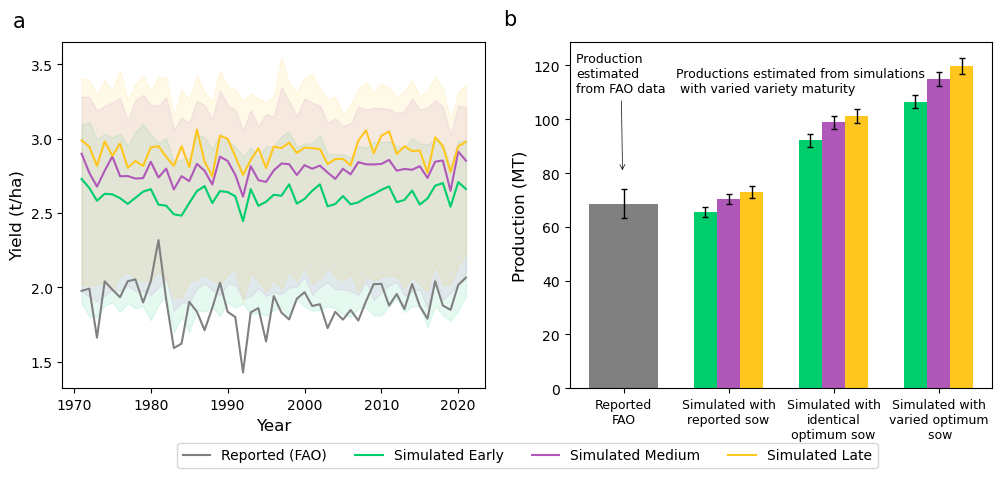

In [21]:
#Plotting  -With fertilizer
fer="wfer"
type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\1_mz_Africa_WeightedYld_Production_"+fer+".csv")
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"+fer+"\\"
type_colors=["#00CD6C", "#AF58BA", "#FFC61E"]
width_ratios = [1, 1]
label=['Early','Medium','Later']

#####################################
fig, axes = plt.subplots(1, 2, figsize=(12,4.5),gridspec_kw={'width_ratios': width_ratios}) #
#fig, ax = plt.subplots(1, 2, figsize=(13,4.5))
sw=['fao','ReportedSow','FixedSow','OptimumYearSow']  #['ReportedSow','FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
label_name=['Simulated Early', 'Simulated Medium','Simulated Late']
x=list(range(1971,2022))
y=result[(result['sowtype']=='fao')&(result['type']=='yld')].iloc[0,4:].values
axes[0].plot(x,y,color='grey',label="Reported (FAO)") #FAO
for cul in range(3):
    y1=result[(result['sowtype']=='ReportedSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==cul+1)].iloc[0,4:].values*0.6
    y2=result[(result['sowtype']=='OptimumYearSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==cul+1)].iloc[0,4:].values*0.6
    axes[0].fill_between(x,[float(y) for y in y1],[float(y) for y in y2],color=type_colors[cul],alpha=0.1)
    y=result[(result['sowtype']=='OptimumFixedSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==cul+1)].iloc[0,4:].values*0.6
    axes[0].plot(x,y,color=type_colors[cul],label=label_name[cul])

#Bar
mzarea=area[['se1a','se2a']].sum().sum()
xtick = [1,2,3,4]
bar_width=0.66
#fao
mean=np.mean(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
sd=np.std(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
axes[1].bar(xtick[0],mean,bar_width,yerr=sd,color='grey',error_kw=dict(lw=1, capsize=2, capthick=1))

#simulated
for ty in [1,2,3]: #sowing type
    for cul in [1,2,3]: #variety
        mean1=result[(result['sowtype']==sw[ty])&(result['type']=="yld")&
                             (result['sea']==1)&(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].values*0.6*(area.se1a.sum())/1000000
        mean2=result[(result['sowtype']==sw[ty])&(result['type']=="prod")&
                             (result['sea']==2)&(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].values*0.6*(area.se2a.sum())/1000000
        sd=(mean1+mean2).std()
        axes[1].bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean2.mean(),bar_width/3,color=type_colors[cul-1])
        axes[1].bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean1.mean(),bar_width/3,color=type_colors[cul-1],yerr=sd,
               error_kw=dict(lw=1, capsize=2, capthick=1))
axes[0].set_xlabel("Year",fontsize=12)
axes[0].set_ylabel("Yield (t/ha)",fontsize=12)
axes[1].set_ylabel("Production (MT)",fontsize=12)
#axes[1].set_ylabel("")
axes[1].set_xticks([1,2,3,4],['Reported\nFAO','Simulated with\nreported sow','Simulated with\nidentical\noptimum sow',
                              'Simulated with\nvaried optimum\n sow'],fontsize=9)
axes[0].text(1962,3.75,"a",fontsize=15)
axes[1].text(-0.15,135,"b",fontsize=15)
axes[0].legend(loc='lower center',ncol=4,fontsize=10,bbox_to_anchor=(1.1, -0.25))
axes[1].annotate(
    "Production \nestimated\nfrom FAO data",  # The text to display
    xy=(0.99, 80),  # The point the arrow points to
    xytext=(0.55, 110),  # The point where the text is placed
    arrowprops=dict(facecolor="black", arrowstyle="->",linewidth=0.5),  # Arrow properties
    fontsize=9
)
axes[1].text(1.5,110,"Productions estimated from simulations\n with varied variety maturity",fontsize=9)
fig.savefig(fig_dir+"MS1_mz_cul_yield_prod_change_"+fer+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS1_mz_cul_yield_prod_change_"+fer+".pdf",format="pdf",dpi=300)

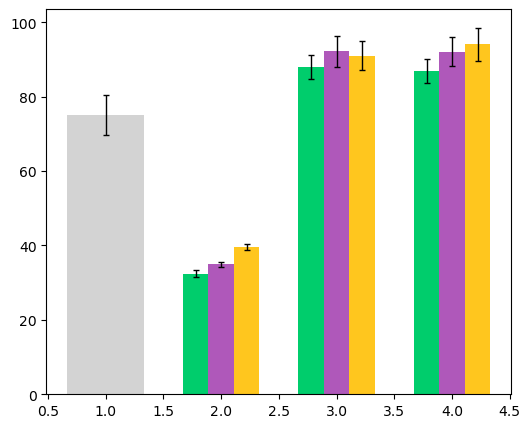

In [304]:
fig, ax = plt.subplots(figsize=(6,5))
# Bar width
mzarea=area[['se1a','se2a']].sum().sum()
xtick = [1,2,3,4]
bar_width=0.66
#fao
mean=np.mean(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
sd=np.std(result[(result['sowtype']=="fao")&(result['type']=="yld")][[str(yr) for yr in range(1971,2022)]].values*mzarea/1000000)
ax.bar(xtick[0],mean,bar_width,yerr=sd,color='lightgrey',error_kw=dict(lw=1, capsize=2, capthick=1))

#simulated
for ty in [1,2,3]: #sowing type
    for cul in [1,2,3]: #variety
        mean1=result[(result['sowtype']==sw[ty])&(result['type']=="prod")&
                             (result['sea']==1)&(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].mean(axis=1)
        mean2=result[(result['sowtype']==sw[ty])&(result['type']=="prod")&
                             (result['sea']==2)&(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].mean(axis=1)
        sd=result[(result['sowtype']==sw[ty])&(result['type']=="prod")
                             &(result['cul']==cul)][[str(yr) for yr in range(1971,2022)]].sum().std()
        ax.bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean2,bar_width/3,color=type_colors[cul-1])
        ax.bar(xtick[ty]-bar_width/3+(bar_width/3)*(cul-1),mean1,bar_width/3,color=type_colors[cul-1],yerr=sd,
               error_kw=dict(lw=1, capsize=2, capthick=1))

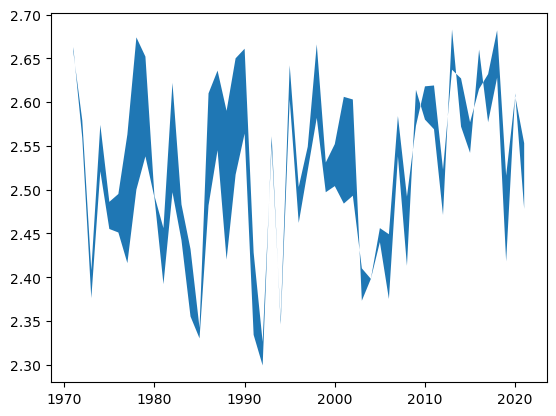

In [200]:
x=np.array(range(1971,2022))
y1=np.array(result[(result['sowtype']=='ReportedSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==1)].iloc[0,4:])
y1=np.array(result[(result['sowtype']=='FixedSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==1)].iloc[0,4:])
#plt.plot(x,y)
y2=result[(result['sowtype']=='OptimumYearSow')&(result['type']=='yld')&(result['sea']==3)&(result['cul']==1)].iloc[0,4:].values

plt.fill_between([x for x in range(1971,2022)], [float(y) for y in y1], [float(y) for y in y2])

In [202]:
list(range(2021,2030))

[2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029]

In [151]:
result.sowtype.unique()

array(['fao', 'ReportedSow', 'FixedSow', 'OptimumFixedSow',
       'OptimumDecadeSow', 'OptimumYearSow'], dtype=object)

In [ ]:
                       
                       for cul in range(3):
    y = result.loc[(result.sowingwindow=="")&(result.type=="yield")&(result.cul==cul+1)&(result.sea==se+1),
                             [str(x) for x in range(1971,2022)]]
        #y.iloc[1,].rolling(wondow=10)
        y = pd.DataFrame(y.values[0])
        x = list(range(1971,2022))
        ax[se,0].plot(x,y,label='Yield',color=type_colors[cul-1])
        ax[se,0].tick_params(axis='both', which='major', labelsize=14)
        #ax2 = ax.twinx()
        ax[se,0].set_xlabel("Year",fontsize=16)
        ax[se,0].set_ylabel("Yield (t/ha)",fontsize=16)         
    for se in range(2):
        
        
        
        #plt.plot()
        y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
        y = y.dropna()
        x = list(range(1975,2021,10))
        ax[se,1].plot(x,y,marker='o',markersize=10,color=type_colors[cul],linestyle=':', label=label[cul]) #,
        #trend
        z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
        p = np.poly1d(z)
        ax[se,1].plot(x, p(x), "-", color=type_colors[cul])
        ax[se,1].set_xticks([1976,1986,1996,2006,2016])
        ax[se,1].set_xticklabels(["1970s","1980s","1990s","2000s","2010s"],fontsize=14)
        ax[se,1].set_xlabel("Decade",fontsize=16)
        ax[se,1].set_ylabel("Suitability Index (SI)",fontsize=16)
        ax[se,1].tick_params(axis='both', which='major', labelsize=14)
        #ax[se,1].set_yticks([0,0.25,0.5,0.75,1,1.25,1.5])
ax[0,1].legend(bbox_to_anchor=(1.46, 1.03), loc='upper right',fontsize=14)
ax[0,0].text(1963,ax[0,0].get_ylim()[1]+0.05,"a",fontsize=20)
ax[1,0].text(1963,ax[1,0].get_ylim()[1]+0.05,"c",fontsize=20)
ax[0,1].text(1964,ax[0,1].get_ylim()[1]+0.05,"b",fontsize=20)
ax[1,1].text(1964,ax[1,1].get_ylim()[1]+0.05,"d",fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.25) #, left=0.1, right=0.95, top=0.9, bottom=0.1)
plt.show()
#fig.savefig(fig_dir+"MS1_mz_yld_temporalchange"+sw+".png",format="png",bbox_inches='tight')
#fig.savefig(fig_dir+"MS1_mz_yld_temporalchange"+sw+".pdf",format="pdf",bbox_inches='tight')

In [ ]:
#########################################SIMULATED VALUE###################################################
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_wfer.csv")  #simulated yield with fertilizer

In [82]:
#Simulated yield and production with reported sowing month
#Resport sowing month and area for the primary and minor maize
in_dir="D:\\works\\AfricaMzSg\\input\\"
#reported sowing month
sow=pd.read_csv(in_dir+"Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m','A']]
sow.columns=['SIMUNIT','se1m','se2m','A']
area=pd.read_csv(in_dir+"Africa_SIMUNIT_MZ_PhysicalArea.csv")
area=area.merge(sow[['SIMUNIT','A']],how='outer').fillna(0)
area['se1a']=area['PhysicalArea']#Area of the primary maize is set to the physical area of maize in around 2020 (SPAM)
area['se2a']=area['A']-area['PhysicalArea']#Actual area of second maize is not know, setting to Physical-Harvest>0
area[area<0]=0
sow=sow[['SIMUNIT','se1m','se2m']]
area=area[['SIMUNIT','se1a','se2a']]

In [83]:
###################################PRODUCTION WITH REPORTED CALENDAR########################################
#Compute yield and production with reported sowing month
result=pd.DataFrame(columns=['sowtype','type','cul','sea']+[x for x in range(1971,2022)])
for cul in range(3):
    df=yld.iloc[:,(2+cul*12):(14+cul*12)]
    df=pd.concat([yld[['SIMUNIT','year']],df],axis=1).merge(sow,on='SIMUNIT',how='left')
    mz_a=0
    #for sea in range(2):
    #season 1
    se=df['se1m'].tolist()  #Reported sowing month for primary season
    sey=[0 if np.isnan(se[i]) else df.iloc[i,int(se[i]+1)] for i in range(len(se))] #select yield at reported sowing month
    df['yld']=[x if x>=1 else 0 for x in sey] #ignore maize area with yield less than 1t/ha
    sey=pd.pivot_table(df, values='yld', index='SIMUNIT',columns='year', aggfunc="mean").reset_index()
    sey=sey.merge(area[['SIMUNIT','se1a']],how='inner')
    prod1=np.dot(sey[[x for x in range(1971,2022)]].values.T,sey['se1a'].values)/1000000
    result.loc[len(result),]=['reported','prod',cul,1]+prod
    yld=1000000*temp['prod']/(sey['se1a'].sum())
    result.loc[len(result),]=['reported','yld',cul,1]+[round(y,3) for y in yld]
    a1=sey['se1a'].sum()
    #Season 2
    se=df['se2m'].tolist()  #Reported sowing month for primary season
    sey=[0 if np.isnan(se[i]) else df.iloc[i,int(se[i]+1)] for i in range(len(se))] #select yield at reported sowing month
    df['yld']=[x if x>=1 else 0 for x in sey] #ignore maize area with yield less than 1t/ha
    sey=pd.pivot_table(df, values='yld', index='SIMUNIT',columns='year', aggfunc="mean").reset_index()
    sey=sey.merge(area[['SIMUNIT','se2a']],how='inner')
    prod1=np.dot(sey[[x for x in range(1971,2022)]].values.T,sey['se2a'].values)/1000000
    result.loc[len(result),]=['reported','prod',cul,2]+prod
    yld=1000000*temp['prod']/(sey['se2a'].sum())
    result.loc[len(result),]=['reported','yld',cul,2]+[round(y,3) for y in yld]
    a2=sey['se2a'].sum()
    #aggreated yld
    yld=list(prod1.values+prod2.values)/(a1+a2)
    result.loc[len(result),]=['reported','yld',cul,2]+[round(y,3) for y in yld]

        
        

In [81]:
#############################Production WITH OPTIMUM CALENDAR#############################################
sow=pd.read_csv(in_dir+"Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m','A']]

(50, 6)

In [76]:
#############################PRODUCTION WITH YEARLY OPTIMUM SOWING MONTH##################################


,sowtype,season,variety,year,yld,prod
0,report,1,E,1971,3.080109,108.787450
1,report,1,E,1972,2.936422,103.712519
2,report,1,E,1973,2.907411,102.687890
3,report,1,E,1974,3.062820,108.176803
4,report,1,E,1975,3.093052,109.244590
...,...,...,...,...,...,...
46,report,1,L,2017,3.523610,124.451634
47,report,1,L,2018,3.300076,116.556558
48,report,1,L,2019,3.303605,116.681200
49,report,1,L,2020,3.526506,124.553912


In [91]:
result[(result['sowtype']=='report')&(result['season']==1)]['yld'].mean()

3.1975853586976815

In [ ]:

#Identical optimum sowing month


#Varying optimum sowing month

In [ ]:
#Estimate yield change over time, yield is aggreated into the continent
sowing_window=['ReportedSow','FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
in_dir="D:/works/AfricaMzSg/output/"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
result=pd.DataFrame(columns=['sowingwindow','type','cul','sea']+[x for x in range(1971,2022)])
#area=pd.DataFrame(columns=['sowingwindow','cul','sea','area'])
for sw in sowing_window:
    yld=pd.read_csv(in_dir+"mz_yield_"+sw+".txt",delim_whitespace=True)
    for cul in [1,2,3]:
        for se in [1,2]:
            temp=yld[(yld['matu']==cul)&(yld['sea']==se)].fillna(0)
            #for season 1, we always extract yield, for season 2, we extract yield for grids with >80% yearly yield greater 1
            temp['G1count']=[(temp.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in temp.index]
            temp=temp[temp.G1count>=(51*0.8)].drop('G1count',axis=1) #only keep rows that >80% years yield greater 1 
            temp=temp.merge(df,how='left').fillna(0) #merge maize area
            result.loc[len(result),]=[sw,'yield',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)/sum(temp["A"]),3) for x in range(1971,2022)]
            result.loc[len(result),]=[sw,'prod',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)) for x in range(1971,2022)]
            #area.loc[len(area)]=[sw,cul,se,sum(temp["A"])]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\1_mz_Africa_WeightedYld_Production_Over80%G1.csv", index=False)

In [ ]:
        #df['se1yld']=[np.nan if np.isnan(se[i]) else temp.iloc[i,int(se[i]-1)] for i in range(len(se))]
se=yld['se2m'].tolist() #Reported sowing month for minor season
se2y=[0 if np.isnan(se[i]) else yld.loc[i,int(se[i]-1)] for i in range(len(se))]
yld['se2y']=[x if x>=1 else 0 for x in se2y]
#df['se2yld']=[np.nan if np.isnan(se[i]) else temp.iloc[i,int(se[i]-1)] for i in range(len(se))]
#season1
temp=pd.pivot_table(yld, values='se1y', index='SIMUNIT',columns='year', aggfunc="mean").reset_index()
temp=temp.merge(area[['SIMUNIT','se1a']],how='inner')
prod1=np.dot(temp[[x for x in range(1971,2022)]].values.T,temp['se1a'].values)/1000000
#season2
temp=pd.pivot_table(yld, values='se2y', index='SIMUNIT',columns='year', aggfunc="mean").reset_index()
temp=temp.merge(area[['SIMUNIT','se2a']],how='inner')
prod2=np.dot(temp[[x for x in range(1971,2022)]].values.T,temp['se2a'].values)/1000000

=(prod1+prod2)/

In [85]:
#Estimate yield change over time, yield is aggreated into the continent
sowing_window=['ReportedSow','FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
in_dir="D:/works/AfricaMzSg/output/"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
result=pd.DataFrame(columns=['sowingwindow','type','cul','sea']+[x for x in range(1971,2022)])
#area=pd.DataFrame(columns=['sowingwindow','cul','sea','area'])
for sw in sowing_window:
    yld=pd.read_csv(in_dir+"mz_yield_"+sw+".txt",delim_whitespace=True)
    for cul in [1,2,3]:
        for se in [1,2]:
            temp=yld[(yld['matu']==cul)&(yld['sea']==se)].fillna(0)
            #for season 1, we always extract yield, for season 2, we extract yield for grids with >80% yearly yield greater 1
            temp['G1count']=[(temp.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in temp.index]
            temp=temp[temp.G1count>=(51*0.8)].drop('G1count',axis=1) #only keep rows that >80% years yield greater 1 
            temp=temp.merge(df,how='left').fillna(0) #merge maize area
            result.loc[len(result),]=[sw,'yield',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)/sum(temp["A"]),3) for x in range(1971,2022)]
            result.loc[len(result),]=[sw,'prod',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)) for x in range(1971,2022)]
            #area.loc[len(area)]=[sw,cul,se,sum(temp["A"])]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\1_mz_Africa_WeightedYld_Production_Over80%G1.csv", index=False)
#only optimize sowing month, with cultivars using the their mean
df=pd.DataFrame(columns=['Type','Season','Prod_mean','Prod_cv'])
for se in [1,2]:
    for sw in range(len(sowing_window)):
        prod=result[(result.sowingwindow==sowing_window[sw])&(result.sea==se)&(result.type=="prod")].iloc[:,4:].mean()
        df.loc[len(df),:]=[sowing_window[sw],se,prod.mean(),100*prod.std()/prod.mean()]

In [84]:
df #using 5min grid area

,Type,Season,Prod_mean,Prod_cv
0,ReportedSow,1,31787579.300654,2.176623
1,FixedSow,1,85983327.346405,3.668783
2,OptimumFixedSow,1,86973085.601307,3.990191
3,OptimumDecadeSow,1,87110905.535948,3.842976
4,OptimumYearSow,1,87564479.20915,3.779341
5,ReportedSow,2,15228686.888889,4.190129
6,FixedSow,2,18883043.764706,4.899329
7,OptimumFixedSow,2,19013146.882353,5.255394
8,OptimumDecadeSow,2,16368084.124183,5.094193
9,OptimumYearSow,2,12797616.803922,6.343227


In [86]:
df #using seg cul cluster area

,Type,Season,Prod_mean,Prod_cv
0,ReportedSow,1,31787157.379085,2.176684
1,FixedSow,1,85925957.457516,3.669804
2,OptimumFixedSow,1,86814263.372549,3.992365
3,OptimumDecadeSow,1,86963472.052288,3.845414
4,OptimumYearSow,1,87419850.535948,3.781742
5,ReportedSow,2,15193318.836601,4.186883
6,FixedSow,2,18847416.620915,4.900243
7,OptimumFixedSow,2,18975061.065359,5.238304
8,OptimumDecadeSow,2,16335823.823529,5.078857
9,OptimumYearSow,2,12771549.143791,6.325467


In [89]:
sw=1
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\1_mz_Africa_WeightedYld_Production_Over80%G1.csv")
for se in [1,2]:
    for sw in range(len(sowing_window)):
        prod=result[(result.sowingwindow==sowing_window[sw])&(result.sea==se)&(result.type=="prod")].iloc[:,4:].max()
        df.loc[len(df),:]=[sowing_window[sw],se,prod.mean(),100*prod.std()/prod.mean()]
df

,Type,Season,Prod_mean,Prod_cv
0,ReportedSow,1,35023573.202614,2.124581
1,FixedSow,1,89214803.013072,3.852995
2,OptimumFixedSow,1,89854962.019608,4.140694
3,OptimumDecadeSow,1,89784008.117647,3.966455
4,OptimumYearSow,1,89825340.457516,3.837152
5,ReportedSow,2,16829473.862745,3.92743
6,FixedSow,2,19674738.196078,4.775455
7,OptimumFixedSow,2,19903245.803922,5.087747
8,OptimumDecadeSow,2,20712244.013072,9.223477
9,OptimumYearSow,2,24931709.248366,12.080083


In [87]:
#Estimate yield change over time, yield is aggreated into the continent, not remove grids with yield less than 1t/ha
sowing_window=['ReportedSow','FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
in_dir="D:/works/AfricaMzSg/output/"
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
result=pd.DataFrame(columns=['sowingwindow','type','cul','sea']+[x for x in range(1971,2022)])
#area=pd.DataFrame(columns=['sowingwindow','cul','sea','area'])
for sw in sowing_window:
    yld=pd.read_csv(in_dir+"mz_yield_"+sw+".txt",delim_whitespace=True)
    for cul in [1,2,3]:
        for se in [1,2]:
            temp=yld[(yld['matu']==cul)&(yld['sea']==se)].fillna(0)
            #for season 1, we always extract yield, for season 2, we extract yield for grids with >80% yearly yield greater 1
            temp['G1count']=[(temp.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in temp.index]
            #temp=temp[temp.G1count>=(51*0.8)].drop('G1count',axis=1) #only keep rows that >80% years yield greater 1 
            temp=temp.merge(df,how='left').fillna(0)
            result.loc[len(result),]=[sw,'yield',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)/sum(temp["A"]),3) for x in range(1971,2022)]
            result.loc[len(result),]=[sw,'prod',cul,se]+ \
                [round(np.dot(temp["yld_"+str(x)].values,temp["A"].values.T)) for x in range(1971,2022)]
            #area.loc[len(area)]=[sw,cul,se,sum(temp["A"])]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\1_mz_Africa_WeightedYld_Production.csv", index=False)
#only optimize sowing month, with cultivars using the their mean
df=pd.DataFrame(columns=['Type','Season','Prod_mean','Prod_cv'])
for se in [1,2]:
    for sw in range(len(sowing_window)):
        prod=result[(result.sowingwindow==sowing_window[sw])&(result.sea==se)&(result.type=="prod")].iloc[:,4:].mean()
        df.loc[len(df),:]=[sowing_window[sw],se,prod.mean(),100*prod.std()/prod.mean()]

,Type,Season,Prod_mean,Prod_cv
0,ReportedSow,1,35023573.202614,2.124581
1,FixedSow,1,89214803.013072,3.852995
2,OptimumFixedSow,1,89854962.019608,4.140694
3,OptimumDecadeSow,1,89784008.117647,3.966455
4,OptimumYearSow,1,89825340.457516,3.837152
5,ReportedSow,2,16829473.862745,3.92743
6,FixedSow,2,19674738.196078,4.775455
7,OptimumFixedSow,2,19903245.803922,5.087747
8,OptimumDecadeSow,2,20712244.013072,9.223477
9,OptimumYearSow,2,24931709.248366,12.080083


In [170]:
pd.concat(axis=1)

,Seed,Sow,Season,Prod_mean,Prod_cv
0,mean,FixedSow,1,8.612763e+07,3.641679
1,optim_fixed,OptimumFixedSow,1,9.174573e+07,4.801694
2,optim_decade,OptimumDecadeSow,1,9.174752e+07,4.625990
3,optim_year,OptimumYearSow,1,9.751811e+07,3.999404
4,mean,FixedSow,2,1.888681e+07,4.828448
5,optim_fixed,OptimumFixedSow,2,2.407266e+07,6.938889
6,optim_decade,OptimumDecadeSow,2,2.169648e+07,7.571600
7,optim_year,OptimumYearSow,2,2.252479e+07,8.036676


[86973085.6013072, 3.990191488091985]

[87110905.53594771, 3.842976093138832]

[87564479.20915033, 3.779340565154793]

In [40]:
season=1
seg=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se"+str(season)+"_cul_cluster_1971-2021.csv")
seg=seg[['SIMUNIT','s'+str(season)+'c','s'+str(season)+'m','A']]
#            +[item for item in seg.columns[7:] if float(item.split('_')[2][2:])>3]] 
A=seg[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()

In [165]:
def FindOptimCulYld_decade(group):
    out=[]
    for i in range(5):
        if i<4:
            group0=group[["yld_"+str(yr) for yr in range(1971+i*10,1971+(i+1)*10)]].values
        else:
            group0=group[["yld_"+str(yr) for yr in range(1971+i*10,2022)]+['A']].values
        mean=group0[:,:10].mean(1)
        std=group0[:,:10].std(1)
        index=np.argmax(mean**2/100*std)
        out=out+group0[index].tolist()
    return out
def FindOptimCulYld_year(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.max(axis=0)
def FindOptimCulYld_fixed(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values #
    mean=group0[:,:51].mean(1)
    std=group0[:,:51].std(1)
    index=np.argmax(mean**2/100*std)
    return group0[index]
def FindMeanCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.mean(axis=0)
A=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
A=A[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
A=A[(A['SIMUNIT']>0)&(A['A']>0)]

result=pd.DataFrame(columns=['Seed','Sow','Season','Prod_mean','Prod_cv'])
seed_type=['mean','optim_fixed','optim_decade','optim_year']
sowing_window=['FixedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow']
func=[FindMeanCulYld,FindOptimCulYld_fixed,FindOptimCulYld_decade,FindOptimCulYld_year]
in_dir="D:/works/AfricaMzSg/output/"
for se in [1,2]: #season
    for ty in range(4):
        yld=pd.read_csv(in_dir+"mz_yield_"+sowing_window[ty]+".txt",delim_whitespace=True)
        yld=yld[yld.sea==se].drop('sea',axis=1) #selected only season 1
        yld=yld.merge(A).fillna(0)
        temp=yld.groupby('SIMUNIT').apply(func[ty]).reset_index() #
        df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
        df.fillna(0,inplace=True)
        df['G1Count']=[(df.iloc[i,:51]>=1).sum() for i in range(df.shape[0])]
        df=df[df['G1Count']>=(51*0.8)].drop('G1Count',axis=1)#only keep rows that >80% years yield greater 1
        #prod=np.dot(df.loc[:,["yld_"+str(yr) for yr in range(1971,2022)]].T,df.loc[:,'A'])        
        prod=np.dot(df.iloc[:,:51].T,df.iloc[:,51])
        result.loc[len(result)]=[seed_type[ty],sowing_window[ty],se,prod.mean(),prod.std()*100/prod.mean()]

In [167]:
#df['G1Count']=[(df.iloc[i,:51]>=1).sum() for i in range(df.shape[0])]
#df=df[df['G1Count']>=(51*0.8)].drop('G1Count',axis=1)
#df.shape
#[(df.iloc[0,:51]>=1).sum() for i in temp.index]
#df.head()

In [142]:
def FindOptimCulYld_decade(group):
    out=[]
    for i in range(5):
        if i<4:
            group0=group[["yld_"+str(yr) for yr in range(1971+i*10,1971+(i+1)*10)]].values
        else:
            group0=group[["yld_"+str(yr) for yr in range(1971+i*10,2022)]+['A']].values
        mean=group0[:,:10].mean(1)
        std=group0[:,:10].std(1)
        index=np.argmax(mean**2/100*std)
        out=out+group0[index].tolist()
    return out
def FindMeanCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.mean(axis=0)
def FindOptimCulYld_fixed(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values #
    mean=group0[:,:51].mean(1)
    std=group0[:,:51].std(1)
    index=np.argmax(mean**2/100*std)
    return group0[index]
def FindOptimCulYld_year(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.max(axis=0)
sea=1
in_dir="D:/works/AfricaMzSg/output/"
yld=pd.read_csv(in_dir+"mz_yield_"+sowing_window[3]+".txt",delim_whitespace=True)
yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1
yld=yld.merge(A,how='left').fillna(0)
temp=yld.groupby('SIMUNIT').apply(FindOptimCulYld_year).reset_index()
df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
prod=np.dot(df.iloc[:,:51].T,df.iloc[:,51])
#yld.head()

In [144]:
[prod.mean(),prod.std()*100/prod.mean()]

[96817483.50963776, 4.17063327748684]

In [150]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1.325,4.270,0.000,5.015,3.912,3.126,1.195,0.514,0.348,2.290,...,0.000,0.000,1.627,0.000,1.626,0.977,1.169,2.419,0.000,809.699997
1,0.135,0.000,0.188,0.157,0.143,0.168,0.165,0.150,0.145,0.152,...,0.163,0.137,0.158,0.141,0.144,0.168,0.139,0.144,0.129,1049.600001
2,0.211,0.156,0.546,0.000,0.151,0.170,0.167,3.591,0.158,0.155,...,0.136,0.145,0.157,0.000,0.158,0.165,0.149,0.161,0.159,133.899994
3,0.152,0.100,0.152,0.138,0.153,0.150,0.159,0.163,0.028,0.145,...,0.113,0.145,0.209,0.168,0.174,0.115,0.000,0.162,0.136,178.499994
4,0.000,0.000,0.148,0.135,0.133,0.148,0.161,0.000,0.124,0.156,...,0.000,0.148,0.000,0.000,0.167,0.000,0.128,0.142,0.138,397.599998


In [38]:
sw=sowing_window[4]
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index()
df=df[(df['SIMUNIT']>0)&(df['A']>0)]
len(df.SIMUNIT.unique())

14940

In [44]:
sw=sowing_window[1]
yld=pd.read_csv(in_dir+"mz_yield_"+sw+".txt",delim_whitespace=True)
len(yld.SIMUNIT.unique())

12606

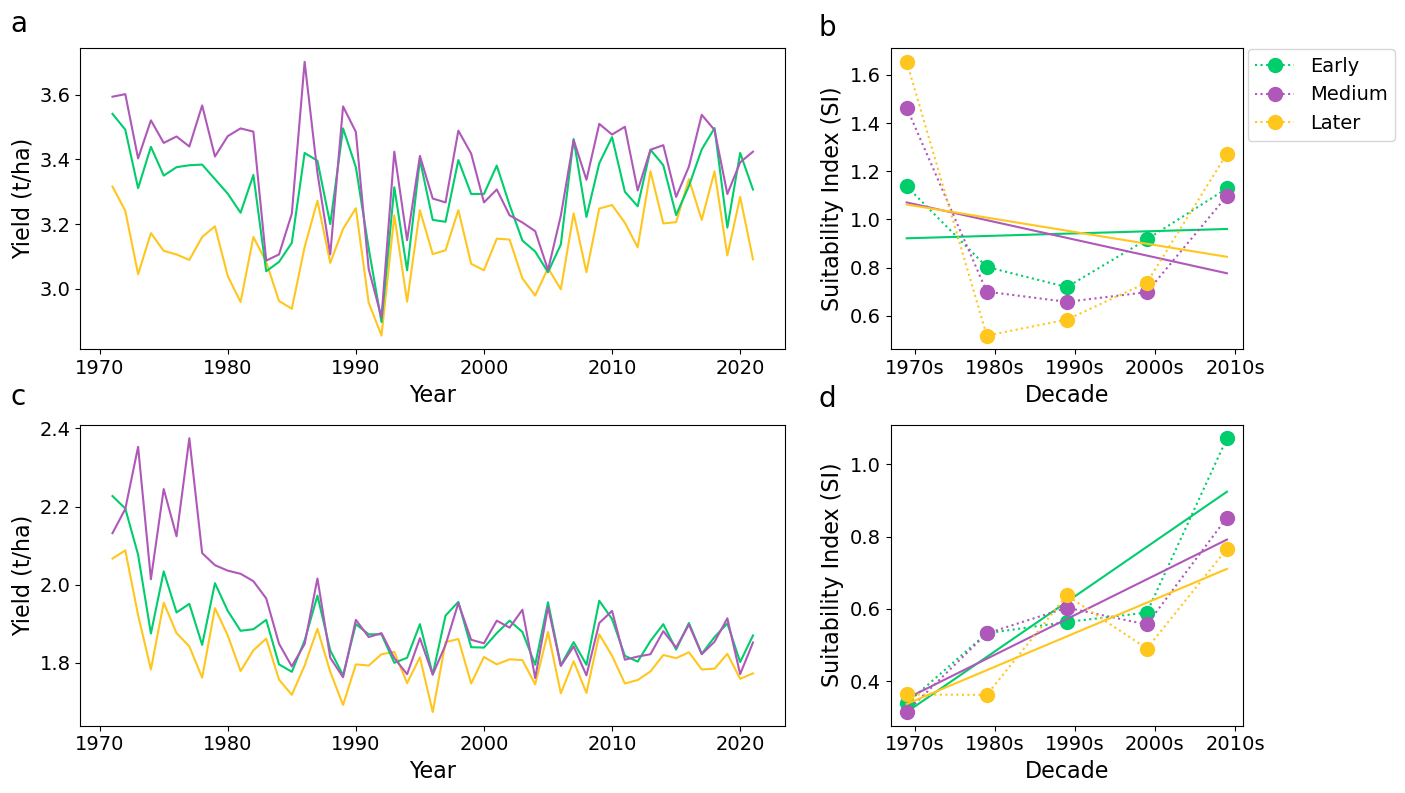

In [178]:
#Plotting
#type_colors = {-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"} #blue, red, green
result=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\1_mz_Africa_WeightedYld_Production_Over80%G1.csv")
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\"
type_colors=["#00CD6C", "#AF58BA", "#FFC61E"]
width_ratios = [2, 1]
label=['Early','Medium','Later']
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': width_ratios},figsize=(15,8.8))
sw=sowing_window[1]
for cul in range(3):
    for se in range(2):
        y = result.loc[(result.sowingwindow=="OptimumFixedSow")&(result.type=="yield")&(result.cul==cul+1)&(result.sea==se+1),
                             [str(x) for x in range(1971,2022)]]
        #y.iloc[1,].rolling(wondow=10)
        y = pd.DataFrame(y.values[0])
        x = list(range(1971,2022))
        ax[se,0].plot(x,y,label='Yield',color=type_colors[cul-1])
        ax[se,0].tick_params(axis='both', which='major', labelsize=14)
        #ax2 = ax.twinx()
        ax[se,0].set_xlabel("Year",fontsize=16)
        ax[se,0].set_ylabel("Yield (t/ha)",fontsize=16)
        
        
        #plt.plot()
        y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
        y = y.dropna()
        x = list(range(1975,2021,10))
        ax[se,1].plot(x,y,marker='o',markersize=10,color=type_colors[cul],linestyle=':', label=label[cul]) #,
        #trend
        z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
        p = np.poly1d(z)
        ax[se,1].plot(x, p(x), "-", color=type_colors[cul])
        ax[se,1].set_xticks([1976,1986,1996,2006,2016])
        ax[se,1].set_xticklabels(["1970s","1980s","1990s","2000s","2010s"],fontsize=14)
        ax[se,1].set_xlabel("Decade",fontsize=16)
        ax[se,1].set_ylabel("Suitability Index (SI)",fontsize=16)
        ax[se,1].tick_params(axis='both', which='major', labelsize=14)
        #ax[se,1].set_yticks([0,0.25,0.5,0.75,1,1.25,1.5])
ax[0,1].legend(bbox_to_anchor=(1.46, 1.03), loc='upper right',fontsize=14)
ax[0,0].text(1963,ax[0,0].get_ylim()[1]+0.05,"a",fontsize=20)
ax[1,0].text(1963,ax[1,0].get_ylim()[1]+0.05,"c",fontsize=20)
ax[0,1].text(1964,ax[0,1].get_ylim()[1]+0.05,"b",fontsize=20)
ax[1,1].text(1964,ax[1,1].get_ylim()[1]+0.05,"d",fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.25) #, left=0.1, right=0.95, top=0.9, bottom=0.1)
plt.show()
#fig.savefig(fig_dir+"MS1_mz_yld_temporalchange"+sw+".png",format="png",bbox_inches='tight')
#fig.savefig(fig_dir+"MS1_mz_yld_temporalchange"+sw+".pdf",format="pdf",bbox_inches='tight')